### This example demonstrates the XCSF supervised learning mechanisms to perform classification
Classifiers are composed of neural network conditions and predictions. A softmax layer is used as prediction output and labels are one-hot encoded. Similar to regression, a single dummy action is performed such that [A] = [M].

In [1]:
from __future__ import annotations

from typing import Final

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm import tqdm

import xcsf

### Load training and test data
Loads USPS data from: https://www.openml.org/d/41082 

"Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990)."

In [2]:
data = fetch_openml(data_id=41082)  # 256 features, 10 classes, 9298 instances
INPUT_HEIGHT: Final[int] = 16
INPUT_WIDTH: Final[int] = 16
INPUT_CHANNELS: Final[int] = 1
    
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.1
)

# numpy
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# scale features [0,1]
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

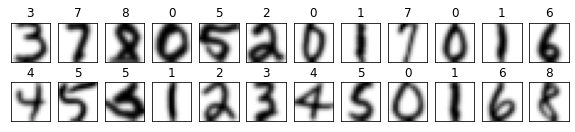

In [3]:
plt.figure(figsize=(10,2))
for i in range(24):
    plt.subplot(2,12,i+1);
    plt.imshow(X_train[i].reshape(INPUT_WIDTH, INPUT_HEIGHT), cmap = "gray_r")
    label = int(y_train[i]) - 1  # USPS labels start at 1
    plt.title(f"{label}")
    plt.xticks([])
    plt.yticks([])
plt.show()

In [4]:
# one hot encode labels
onehot_encoder = OneHotEncoder(sparse=False, categories="auto")
onehot_encoder.fit(y_train.reshape(-1, 1))
y_train = onehot_encoder.transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

# 10% of training for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

# get number of input and output variables
X_DIM: Final[int] = np.shape(X_train)[1]
Y_DIM: Final[int] = np.shape(y_train)[1]
    
print(f"X_train shape = {np.shape(X_train)}")
print(f"y_train shape = {np.shape(y_train)}")
print(f"X_val shape = {np.shape(X_val)}")
print(f"y_val shape = {np.shape(y_val)}")
print(f"X_test shape = {np.shape(X_test)}")
print(f"y_test shape = {np.shape(y_test)}")  

X_train shape = (7531, 256)
y_train shape = (7531, 10)
X_val shape = (837, 256)
y_val shape = (837, 10)
X_test shape = (930, 256)
y_test shape = (930, 10)


### Initialise XCSF

In [5]:
xcs: xcsf.XCS = xcsf.XCS(X_DIM, Y_DIM, 1)  # initialise for supervised learning

xcs.OMP_NUM_THREADS = 8
xcs.POP_SIZE = 500
xcs.MAX_TRIALS = 1000  # number of trials per fit()
xcs.LOSS_FUNC = "onehot"  # one-hot encoding classification error
xcs.E0 = 0.01  # 1% target error
xcs.ALPHA = 1
xcs.BETA = 0.05
xcs.NU = 5
xcs.THETA_EA = 100
xcs.THETA_DEL = 100
xcs.action("integer")  # (dummy) integer actions

ACTIVATION: Final[str] = "selu"
SGD_WEIGHTS: Final[bool] = True
EVOLVE_WEIGHTS: Final[bool] = True
EVOLVE_CONNECT: Final[bool] = True
EVOLVE_ETA: Final[bool] = True
EVOLVE_NEURONS: Final[bool] = True
ETA: Final[float] = 0.01
ETA_MIN: Final[float] = 0.00001
MOMENTUM: Final[float] = 0.9
DECAY: Final[float] = 0
N_INIT: Final[int] = 5
N_MAX: Final[int] = 100
MAX_GROW: Final[int] = 1

CONDITION_LAYERS: Final[dict] = {
    "layer_0": {  # hidden layer
        "type": "connected",
        "activation": ACTIVATION,
        "evolve_weights": EVOLVE_WEIGHTS,
        "evolve_connect": EVOLVE_CONNECT,
        "evolve_neurons": EVOLVE_NEURONS,
        "n_init": 1,
        "n_max": N_MAX,
        "max_neuron_grow": MAX_GROW,
    },
    "layer_1": {  # output layer
        "type": "connected",
        "activation": "linear",
        "evolve_weights": EVOLVE_WEIGHTS,
        "evolve_connect": EVOLVE_CONNECT,
        "n_init": 1,
    },
}
xcs.condition("neural", CONDITION_LAYERS)  # neural network conditions

LAYER_CONV: Final[dict] = {
    "type": "convolutional",
    "activation": ACTIVATION,
    "sgd_weights": SGD_WEIGHTS,
    "evolve_weights": EVOLVE_WEIGHTS,
    "evolve_connect": EVOLVE_CONNECT,
    "evolve_eta": EVOLVE_ETA,
    "evolve_neurons": EVOLVE_NEURONS,
    "max_neuron_grow": MAX_GROW,
    "eta": ETA,
    "eta_min": ETA_MIN,
    "momentum": MOMENTUM,
    "decay": DECAY,
    "n_init": N_INIT,
    "n_max": N_MAX,
    "stride": 1,
    "size": 3,
    "pad": 1,
    "height": INPUT_HEIGHT,
    "width": INPUT_WIDTH,
    "channels": INPUT_CHANNELS,
}

LAYER_MAXPOOL: Final[dict] = {
    "type": "maxpool",
    "stride": 2,
    "size": 2,
    "pad": 0,
    "height": INPUT_HEIGHT,
    "width": INPUT_WIDTH,
    "channels": INPUT_CHANNELS,
}

LAYER_CONNECTED: Final[dict] = {
    "type": "connected",
    "activation": ACTIVATION,
    "sgd_weights": SGD_WEIGHTS,
    "evolve_weights": EVOLVE_WEIGHTS,
    "evolve_connect": EVOLVE_CONNECT,
    "evolve_eta": EVOLVE_ETA,
    "evolve_neurons": EVOLVE_NEURONS,
    "max_neuron_grow": MAX_GROW,
    "eta": ETA,
    "eta_min": ETA_MIN,
    "momentum": MOMENTUM,
    "decay": DECAY,
    "n_init": N_INIT,
    "n_max": N_MAX,
}

PREDICTION_LAYERS: Final[dict] = {
    "layer_0": LAYER_CONV,
    "layer_1": LAYER_MAXPOOL,
    "layer_2": LAYER_CONV,
    "layer_3": LAYER_MAXPOOL,
    "layer_4": LAYER_CONNECTED,
    "layer_out1": {  # output layer - softmax composed of two layers
        "type": "connected",
        "activation": "linear",
        "sgd_weights": SGD_WEIGHTS,
        "evolve_weights": EVOLVE_WEIGHTS,
        "evolve_connect": EVOLVE_CONNECT,
        "evolve_eta": EVOLVE_ETA,
        "eta": ETA,
        "eta_min": ETA_MIN,
        "momentum": MOMENTUM,
        "decay": DECAY,
        "n_init": Y_DIM,
    },
    "layer_out2": {  # output layer - softmax composed of two layers
        "type": "softmax",
        "scale": 1,
    },
}
xcs.prediction("neural", PREDICTION_LAYERS)  # neural network predictions

print(xcs.json_parameters())

{
	"version":	"1.1.6",
	"x_dim":	256,
	"y_dim":	10,
	"n_actions":	1,
	"omp_num_threads":	8,
	"pop_init":	true,
	"max_trials":	1000,
	"perf_trials":	1000,
	"pop_size":	500,
	"loss_func":	"onehot",
	"set_subsumption":	false,
	"theta_sub":	100,
	"e0":	0.01,
	"alpha":	1,
	"nu":	5,
	"beta":	0.05,
	"delta":	0.1,
	"theta_del":	100,
	"init_fitness":	0.01,
	"init_error":	0,
	"m_probation":	10000,
	"stateful":	true,
	"compaction":	false,
	"ea":	{
		"select_type":	"roulette",
		"theta_ea":	100,
		"lambda":	2,
		"p_crossover":	0.8,
		"err_reduc":	1,
		"fit_reduc":	0.1,
		"subsumption":	false,
		"pred_reset":	false
	},
	"condition":	{
		"type":	"neural",
		"args":	{
			"layer_0":	{
				"type":	"connected",
				"activation":	"selu",
				"n_inputs":	256,
				"n_init":	1,
				"evolve_weights":	true,
				"evolve_functions":	false,
				"evolve_connect":	true,
				"evolve_neurons":	true,
				"n_max":	100,
				"max_neuron_grow":	1,
				"sgd_weights":	false
			},
			"layer_1":	{
				"type":	"connected",
		

### Run experiment

In [6]:
N: Final[int] = 100  # 100,000 trials
trials: np.ndarray = np.zeros(N)
psize: np.ndarray = np.zeros(N)
msize: np.ndarray = np.zeros(N)
train_err: np.ndarray = np.zeros(N)
val_err: np.ndarray = np.zeros(N)
val_min: float = 1000  # minimum validation error observed
val_trial: int = 0  # number of trials at validation minimum

bar = tqdm(total=N)  # progress bar
for i in range(N):
    # train
    train_err[i] = xcs.fit(X_train, y_train, True)  # True = shuffle
    trials[i] = xcs.time()  # number of learning trials so far
    psize[i] = xcs.pset_size()  # current population size
    msize[i] = xcs.mset_size()  # avg match set size
    # checkpoint lowest validation error
    val_err[i] = xcs.score(X_val, y_val, 1000)  # use maximum of 1000 samples
    if val_err[i] < val_min:
        xcs.store()
        val_min = val_err[i]
        val_trial = trials[i]
    status = (  # update status
        f"trials={trials[i]:.0f} "
        f"train_err={train_err[i]:.5f} "
        f"val_err={val_err[i]:.5f} "
        f"psize={psize[i]:.1f} "
        f"msize={msize[i]:.1f}"
    )
    bar.set_description(status)
    bar.refresh()
    bar.update(1)
bar.close()

trials=100000 train_err=0.01600 val_err=0.02748 psize=500.0 msize=461.2: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:55<00:00, 12.56s/it]


### Plot XCSF learning performance

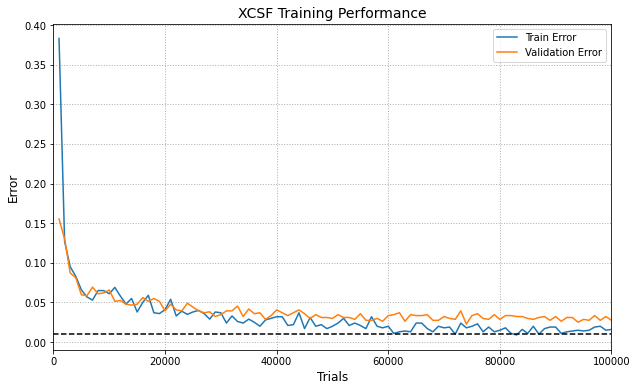

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(trials, train_err, label="Train Error")
plt.plot(trials, val_err, label="Validation Error")
plt.grid(linestyle="dotted", linewidth=1)
plt.axhline(y=xcs.E0, xmin=0, xmax=1, linestyle="dashed", color="k")
plt.title("XCSF Training Performance", fontsize=14)
plt.xlabel("Trials", fontsize=12)
plt.ylabel("Error", fontsize=12)
plt.xlim([0, N * xcs.MAX_TRIALS])
plt.legend()
plt.show()

### Final XCSF test score

In [8]:
print(f"Restoring system from trial {val_trial:.0f} with val_mse={val_min:.5f}")
xcs.retrieve()
pred = xcs.predict(X_test)  # soft max predictions
pred = np.argmax(pred, axis=1)  # select most likely class
pred = onehot_encoder.fit_transform(pred.reshape(-1, 1))
inv_y_test = onehot_encoder.inverse_transform(y_test)
inv_pred = onehot_encoder.inverse_transform(pred)
print(classification_report(inv_y_test, inv_pred, digits=4))

Restoring system from trial 74000 with val_mse=0.02270
              precision    recall  f1-score   support

           0     0.9933    0.9868    0.9900       151
           1     0.9545    0.9767    0.9655        86
           2     0.9919    1.0000    0.9960       123
           3     0.9882    0.9655    0.9767        87
           4     0.9881    0.9651    0.9765        86
           5     0.9639    0.9877    0.9756        81
           6     0.9865    0.9481    0.9669        77
           7     0.9694    0.9896    0.9794        96
           8     0.9333    0.9859    0.9589        71
           9     0.9855    0.9444    0.9645        72

    accuracy                         0.9774       930
   macro avg     0.9755    0.9750    0.9750       930
weighted avg     0.9778    0.9774    0.9774       930



### Confusion Matrix

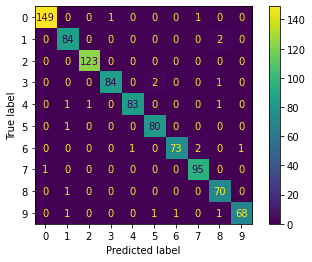

In [9]:
cm = confusion_matrix(inv_y_test, inv_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()